In [252]:

# coding helper agent
# research helper agent
# general purpose agent
# supervisor agent

from dotenv import load_dotenv
from typing import List
import os

load_dotenv(override=True)

from typing import Annotated, Optional
from langchain_community.document_loaders.web_base import WebBaseLoader
from langchain_core.tools import tool
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(
    model="gpt-4o-mini",
    temperature=0
)

# Tools

In [287]:

from typing import Dict
@tool
def scrape_webpages(urls: List[str]) -> str: 
    """Scrapes the content of the given webpages and returns as a single string."""
    print("Scraping webpages:", urls)
    loader = WebBaseLoader(urls)
    print("Loading documents...")

    docs = loader.load()
    print(f"Loaded {len(docs)} documents.")
    return "\n\n".join(
        f'<Document name="{doc.metadata.get("title", "")}">\n{doc.page_content}\n</Document>'
        for doc in docs
    )

@tool
def create_outline(
    points: Annotated[List[str], "A list of main points to include in the outline."],
    file_name: Annotated[str, "File path to save the outline"],
) -> Annotated[str, "Output path of save filed"]:
    """Creates an outline file with the given points."""
    
    file_to_use = os.path.join(os.getcwd(), "temp", file_name)
    with open(file_to_use, "w") as file:
        for i, point in enumerate(points):
            file.write(f"{i + 1} {point}\n")

    return f"Outline saved to {file_to_use}"


@tool
def read_document(
    file_name: Annotated[str, "File path of the document to read"],
    start: Annotated[Optional[int], "Starting position to read from"] = None,
    end: Annotated[Optional[int], "Ending position to read to"] = None,
):
    """Reads a document from a given file path and returns its content as a string."""
    file_to_use = os.path.join(os.getcwd(), "temp", file_name)

    with open(file_to_use, "r") as files:
        lines = files.readlines()
    
    if start is None:
        start = 0

    return "\n".join(lines[start:end])

@tool
def write_document(
    content: Annotated[str, "Content to write to the document"],
    file_name: Annotated[str, "File path to save the document"],
):
    """Create and save a document."""
    file_to_use = os.path.join(os.getcwd(), "temp", file_name)
    with open(file_to_use, "w") as file:
        file.write(content)

    return f"Document saved to {file_to_use}"

@tool
def edit_document(
    file_name: Annotated[str, "File path to save the document"],
    insert: Annotated[Dict[int, str], "A dictionary where keys are line numbers and values are text to insert at those lines"]
):
    """Edits a document at a given file path, by inserting text at specified line numbers"""
    file_to_use = os.path.join(os.getcwd(), "temp", file_name)
    with open(file_to_use, "r") as file:
        lines = file.readlines()

    sorted_items = sorted(insert.items())

    for line_number, text in sorted_items:
        if 1 <= line_number <= len(lines) + 1:
            lines.insert(line_number - 1, text + "\n")
        else:
            return f"Error: Line number {line_number} is out of range."

    with open(file_to_use, "w") as file:
        file.writelines(lines)

    return f"Document {file_to_use} edited and saved successfully."

@tool
def python_repl_tool(
    code: Annotated[str, "The python code to execute and generate the chart"]
):
    """Use this to execute python code."""
    try:
        result = repl.run(code)

    except BaseException as e:
        return f"Failed to execute with exception {repr(e)}"
        
    return f"Successfully executed: \n ```python \n {code}``` \n Stdout: {result}"

@tool
def search_tool(
    query: Annotated[str, "The search query to look up"]
):
    """Use this to search the web for relevant information."""
    try:
        result = "Searching is successful, This is the content to be used"

    except BaseException as e:
        return f"Failed to execute with exception {repr(e)}"
        
    return f"Search results for query '{query}': \n {result}"

# Supervisor

In [288]:
from typing import TypedDict
from typing import Literal
from langgraph.constants import END
from langgraph.types import Command
from langgraph.graph.message import MessagesState
import json
import re


class State(MessagesState):
    next: str

def make_supervisor_node(llm, members: List[str]): 
    options = ["FINISH"] + members
    stringified_options = ", ".join(options)
    system_prompt = (
        "You are a supervisor tasked with managing the conversation between the"
        f"following workers {stringified_options}. Given the following user input,"
        " respond with the worked to act next. Each worked will perform a task and respond"
        "with their results and status. When finished, respond with FINISH."
        "STRICTLY RETURN THE RESPONSE IN JSON FORMAT: {next: <WORKER_NAME or FINISH>}"
    )

    
    class Router(TypedDict):
        next: Literal[str]


    def supervisor(state: State) -> Command[str]:
        messages = [
            { "role": "system", "content": system_prompt}
        ] + state["messages"]

        # response = llm.with_structured_output(Router).invoke(messages)

        response = llm.invoke(messages)
        print("response", response)
        print("Supervisor response:", response.content)
        # response_json = json.load(response.content)
        # print("Parsed JSON:", response_json)

        raw = response.content.strip()

        # Remove ```json ... ```
        raw = re.sub(r"^```json|```$", "", raw, flags=re.MULTILINE).strip()
        print("Cleaned raw response:", raw)
        data = json.loads(raw)
        print("Supervisor parsed data:", data)
        goto = data["next"]

        # goto = response["next"]
        print("Supervisor chose to go to:", goto)
        if goto == "FINISH":
            goto = END
        
        return Command(goto=goto, update={"next": goto})

    return supervisor


# Define the Agents


## Research Team

In [289]:
from langchain_core.messages.human import HumanMessage
from langgraph.prebuilt import create_react_agent

search_agent = create_react_agent(llm, tools=[search_tool])

def search_node(state: State) -> Command:
    results = search_agent.invoke(state)
    # return Command('supervisor', update={"results": results["messages"][-1].content})
    return Command(
        update={
            "messages": [HumanMessage(
                content=results["messages"][-1].content,
                name="search"
            )]
        },
        goto='supervisor',
    )

web_scrapper_agent = create_react_agent(llm, tools=[scrape_webpages])

def web_scrapper_node(state: State) -> Command[Literal['supervisor']]:
    results = web_scrapper_agent.invoke(state)
    print("Web Scrapper results:", results)
    # return Command('supervisor', update={"results": results["messages"][-1].content})
    return Command(
        update={
            "messages": [HumanMessage(
                content=results["messages"][-1].content,
                name="web_scrapper"
            )]
        },
        goto='supervisor',
    )



/var/folders/n4/sl45csd94f3_whtn5fc5dqwr0000gp/T/ipykernel_24850/700612223.py:4: LangGraphDeprecatedSinceV10: create_react_agent has been moved to `langchain.agents`. Please update your import to `from langchain.agents import create_agent`. Deprecated in LangGraph V1.0 to be removed in V2.0.
  search_agent = create_react_agent(llm, tools=[search_tool])
/var/folders/n4/sl45csd94f3_whtn5fc5dqwr0000gp/T/ipykernel_24850/700612223.py:19: LangGraphDeprecatedSinceV10: create_react_agent has been moved to `langchain.agents`. Please update your import to `from langchain.agents import create_agent`. Deprecated in LangGraph V1.0 to be removed in V2.0.
  web_scrapper_agent = create_react_agent(llm, tools=[scrape_webpages])


response content='{\n  "next": "search"\n}' additional_kwargs={'refusal': None} response_metadata={'token_usage': {'completion_tokens': 9, 'prompt_tokens': 101, 'total_tokens': 110, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_provider': 'openai', 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_c4585b5b9c', 'id': 'chatcmpl-Czyk1QFJHkilTfHs9wj85vuSrJfgG', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None} id='lc_run--019bd9e9-be07-76f2-b1bf-6a4343f8877d-0' tool_calls=[] invalid_tool_calls=[] usage_metadata={'input_tokens': 101, 'output_tokens': 9, 'total_tokens': 110, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}}
Supervisor response: {
  "next": "search"
}
Cleaned raw response: {
  "next": "search"
}
Supervisor parsed data: 

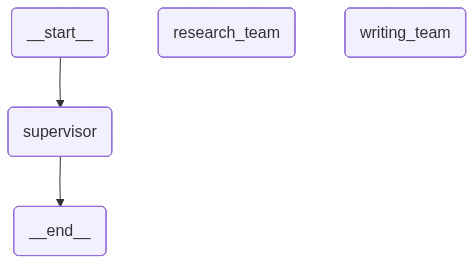

In [290]:
from langgraph.graph import START, END

research_builder = StateGraph(State)
research_supervisor_node = make_supervisor_node(llm, members=["search", "web_scrapper"])
research_builder.add_node('supervisor', research_supervisor_node)
research_builder.add_node('search', search_node)
research_builder.add_node('web_scrapper', web_scrapper_node)

research_builder.add_edge(START, "supervisor")
research_graph = research_builder.compile()

research_graph.invoke({
    "messages": [
        HumanMessage(content="Research the topic of artificial general intelligence and provide relevant information.")
    ]
})

from IPython.display import display, Image

display(Image(super_graph.get_graph().draw_mermaid_png()))


## Writing Team

In [291]:
doc_writer_agent = create_react_agent(
    llm,
    tools=[create_outline, read_document, write_document, edit_document],
    prompt=(
        "you can read, write and edit the documents based on note taker's outlines "
        "Do not ask follow up questions"
    )
)

def doc_writing_node(state:State) -> Command:
    results = doc_writer_agent.invoke(state)
    return Command(
        update={
            "messages": [HumanMessage(
                content=results["messages"][-1].content,
                name="doc_writer"
            )]
        },
        goto='supervisor'
    )

note_taking_agent = create_react_agent(
    llm,
    tools=[create_outline, read_document],
    prompt=(
        "You are a note taker. Create outlines based on the researcher's findings. "
        "Do not ask follow up questions"
    )
)

def note_taking_node(state:State) -> Command:
    results = note_taking_agent.invoke(state)
    return Command(
        update={
            "messages": [HumanMessage(
                content=results["messages"][-1].content,
                name="note_taker"
            )]
        },
        goto='supervisor'
    )

chart_generating_agent = create_react_agent(
    llm,
    tools=[read_document, python_repl_tool],
    prompt=(
        "You are a chart generator. Create charts based on the researcher's findings "
        "and the note taker's outlines. Do not ask follow up questions"
    )
)

def chart_generating_node(state:State) -> Command:
    results = chart_generating_agent.invoke(state)
    return Command(
        update={
            "messages": [HumanMessage(
                content=results["messages"][-1].content,
                name="chart_generator"
            )]
        },
        goto='supervisor'
    )



/var/folders/n4/sl45csd94f3_whtn5fc5dqwr0000gp/T/ipykernel_24850/2941746920.py:1: LangGraphDeprecatedSinceV10: create_react_agent has been moved to `langchain.agents`. Please update your import to `from langchain.agents import create_agent`. Deprecated in LangGraph V1.0 to be removed in V2.0.
  doc_writer_agent = create_react_agent(
/var/folders/n4/sl45csd94f3_whtn5fc5dqwr0000gp/T/ipykernel_24850/2941746920.py:22: LangGraphDeprecatedSinceV10: create_react_agent has been moved to `langchain.agents`. Please update your import to `from langchain.agents import create_agent`. Deprecated in LangGraph V1.0 to be removed in V2.0.
  note_taking_agent = create_react_agent(
/var/folders/n4/sl45csd94f3_whtn5fc5dqwr0000gp/T/ipykernel_24850/2941746920.py:43: LangGraphDeprecatedSinceV10: create_react_agent has been moved to `langchain.agents`. Please update your import to `from langchain.agents import create_agent`. Deprecated in LangGraph V1.0 to be removed in V2.0.
  chart_generating_agent = create

In [292]:
from langgraph.graph import START

doc_writing_supervisor_node = make_supervisor_node(llm, ["note_taker", "doc_writer", "chart_generator"])


writing_builder = StateGraph(State)
writing_builder.add_node("supervisor", doc_writing_supervisor_node)
writing_builder.add_node("note_taker", note_taking_node)
writing_builder.add_node("doc_writer", doc_writing_node)
writing_builder.add_node("chart_generator", chart_generating_node)

writing_builder.add_edge(START, "supervisor")
writing_graph = writing_builder.compile()

In [293]:
from langgraph.graph.state import StateGraph

teams_supervisor_node = make_supervisor_node(llm, ["research_team", "writing_team"])
def call_research_team(state: State) -> Command[Literal['supervisor']]:
    results = research_graph.invoke({ "messages": state["messages"][-1] })
    return Command(
        update={
            "messages": [
                HumanMessage(
                    content=results["messages"][-1].content,
                    name="research_team"
                )
            ]
        },
        goto='supervisor'
    )

def call_writing_team(state: State) -> Command[Literal['supervisor']]:
    results = writing_graph.invoke({ "messages": state["messages"][-1] })
    return Command(
        update={
            "messages": [
                HumanMessage(
                    content=results["messages"][-1].content,
                    name="writing_team"
                )
            ]
        },
        goto='supervisor'
    )

super_builder = StateGraph(State)
super_builder.add_node("supervisor", teams_supervisor_node)
super_builder.add_node("research_team", call_research_team)
super_builder.add_node("writing_team", call_writing_team)

super_builder.add_edge(START, "supervisor")
super_graph = super_builder.compile()



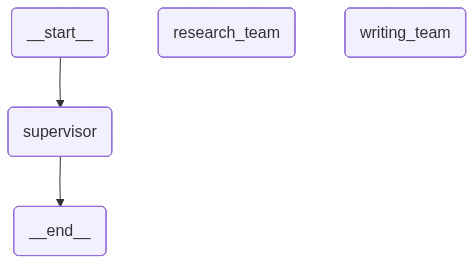

In [294]:

from IPython.display import display, Image

display(Image(super_graph.get_graph().draw_mermaid_png()))

In [295]:
for s in super_graph.stream(
    {
        "messages": [
            ("user", "research why the gold prices has been increasing crazily in 2026")
        ]
    }
):
    print(s)
    print("-----")

# super_graph.invoke(
#     {
#         "messages": [
#             ("user", "research why the gold prices has been increasing crazily in 2026")
#         ]
#     }
# )

response content='{\n  "next": "research_team"\n}' additional_kwargs={'refusal': None} response_metadata={'token_usage': {'completion_tokens': 10, 'prompt_tokens': 103, 'total_tokens': 113, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_provider': 'openai', 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_c4585b5b9c', 'id': 'chatcmpl-CzylJjdAAmHrNkudtybRDR1bENXaN', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None} id='lc_run--019bd9ea-f672-73c2-89cb-c7392ea874a0-0' tool_calls=[] invalid_tool_calls=[] usage_metadata={'input_tokens': 103, 'output_tokens': 10, 'total_tokens': 113, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}}
Supervisor response: {
  "next": "research_team"
}
Cleaned raw response: {
  "next": "research_team"
}
S

FileNotFoundError: [Errno 2] No such file or directory: '/Users/siddeshthorat/Documents/personal-projects/llm-week-2/day-9/temp/gold_price_increase_2026_outline.txt'